In [37]:
import cv2
import numpy as np
import pandas as pd
import os
import random

In [38]:
!pip install opencv-python

In [39]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
def load_data(file_path):
    return np.genfromtxt(file_path, delimiter=',')

In [41]:
data_fragment = load_data(r"/content/dataset/isolated.csv")
solution_fragment = load_data(r"/content/dataset/isolated.csv")

In [42]:
def extract_unique_ids(data):
    return len(np.unique(data[:, 0]))

In [43]:
unique_ids_fragment = extract_unique_ids(data_fragment)
unique_ids_solution = extract_unique_ids(solution_fragment)

In [44]:
def extract_curves(data, size):
    return [data[data[:, 0] == i][:, 2:] for i in range(size)]

In [45]:
curves_fragment = extract_curves(data_fragment, unique_ids_fragment)
curves_solution = extract_curves(solution_fragment, unique_ids_solution)

In [46]:
def plot_curves(curves, size):
    for i in range(size):
        plt.figure(figsize=(8, 8))
        for j in range(i + 1):
            plt.plot(curves[j][:, 0], curves[j][:, 1], linewidth=2)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

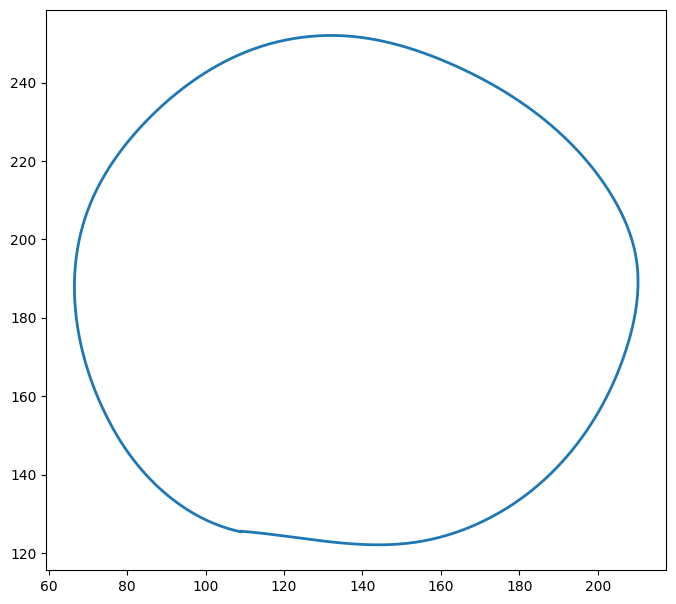

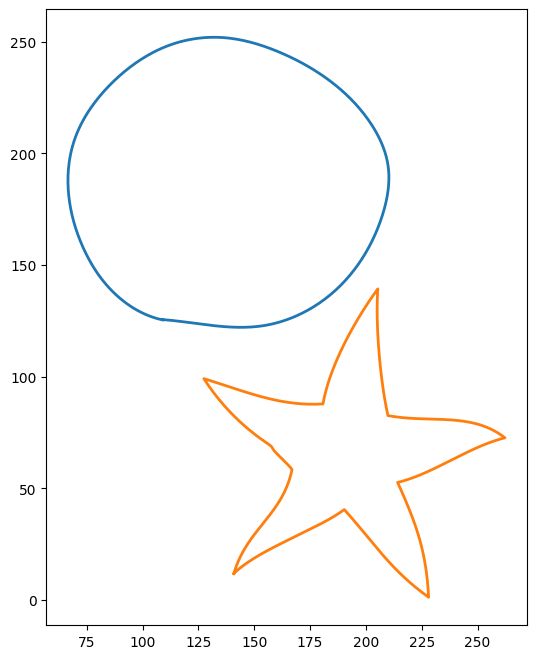

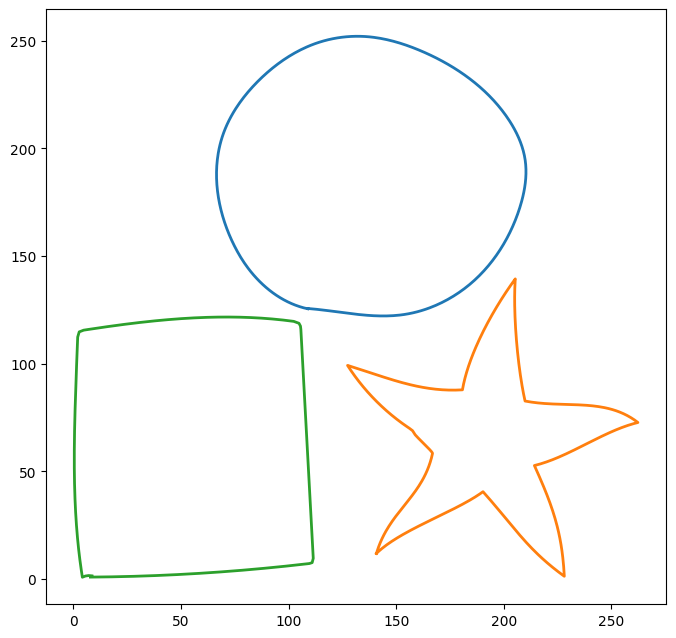

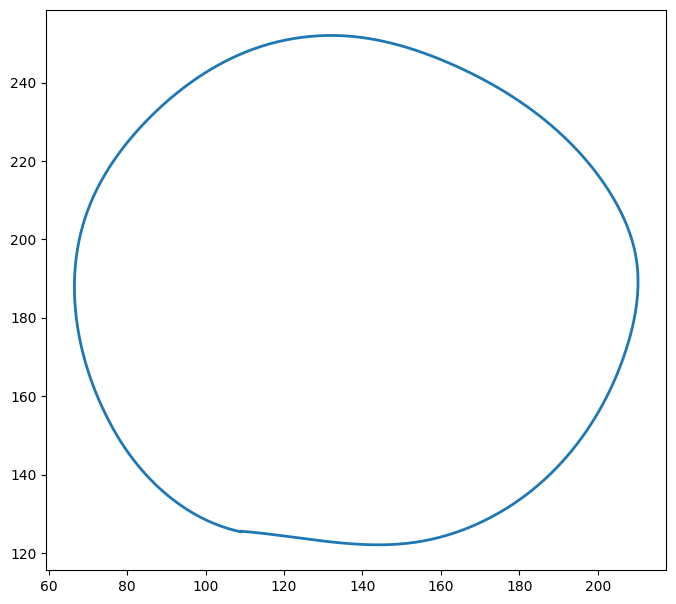

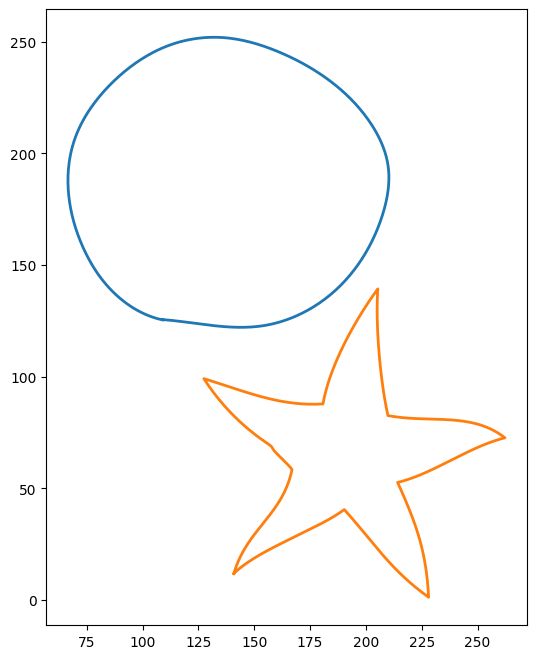

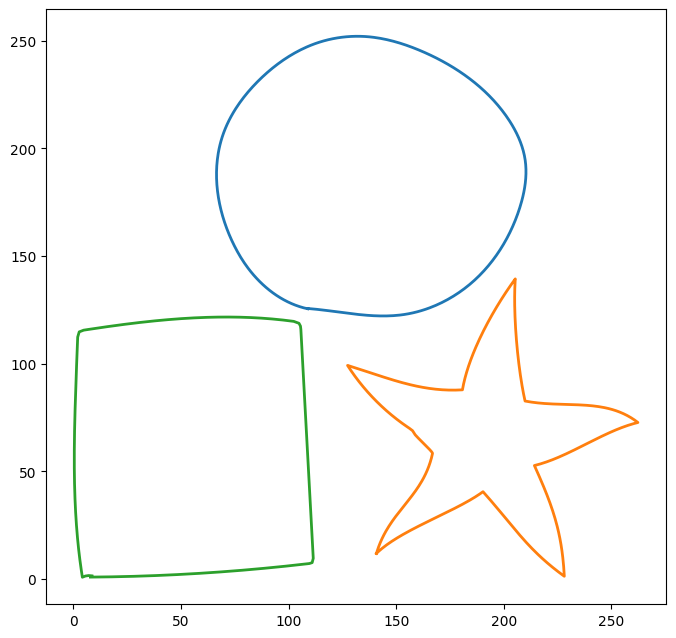

In [47]:
plot_curves(curves_fragment, unique_ids_fragment)
plot_curves(curves_solution, unique_ids_solution)

In [48]:
def identify_endpoints(curves):
    return [curve[0] for curve in curves], [curve[-1] for curve in curves]

In [49]:
start_points_fragment, end_points_fragment = identify_endpoints(curves_fragment)

In [50]:
def create_mappings(size, start_points, end_points):
    curve_indices = {i: i // 2 for i in range(2 * size)}
    partners = {i: i + 1 if i % 2 == 0 else i - 1 for i in range(2 * size)}
    point_map = {2 * i: start_points[i] for i in range(size)}
    point_map.update({2 * i + 1: end_points[i] for i in range(size)})
    return curve_indices, partners, point_map


In [51]:
curve_indices, partners, point_map = create_mappings(unique_ids_fragment, start_points_fragment, end_points_fragment)

In [52]:
def initialize_adjacency_list(size):
    return [[] for _ in range(2 * size)]

In [53]:
adjacency_list = initialize_adjacency_list(unique_ids_fragment)

In [54]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [55]:
def populate_adjacency_list(size, adjacency_list, start_points, end_points):
    for i in range(size):
        adjacency_list[2 * i].append((2 * i + 1, i))
        adjacency_list[2 * i + 1].append((2 * i, i))
        for j in range(size):
            if i != j:
                if euclidean_distance(start_points[i], start_points[j]) < 5:
                    adjacency_list[2 * i].append((2 * j, j))
                if euclidean_distance(start_points[i], end_points[j]) < 5:
                    adjacency_list[2 * i].append((2 * j + 1, j))
                if euclidean_distance(end_points[i], start_points[j]) < 5:
                    adjacency_list[2 * i + 1].append((2 * j, j))
                if euclidean_distance(end_points[i], end_points[j]) < 5:
                    adjacency_list[2 * i + 1].append((2 * j + 1, j))

In [56]:
populate_adjacency_list(unique_ids_fragment, adjacency_list, start_points_fragment, end_points_fragment)

In [57]:
def dfs(node, start_node, visited, path, adjacency_list, partners, unique_cycles):
    path.append(node)
    visited.add(node)

    for neighbor, curve_number in adjacency_list[node]:
        if neighbor == start_node and len(path) > 2:
            curve_path = [curve_indices[path[i]] for i in range(len(path) - 1) if partners[path[i]] == path[i + 1]]
            if partners[path[-1]] == neighbor:
                curve_path.append(curve_indices[neighbor])
            cycle_repr = frozenset(curve_path)
            if cycle_repr not in unique_cycles:
                unique_cycles[cycle_repr] = list(path) + [start_node]
        elif neighbor not in visited:
            dfs(neighbor, start_node, visited, path, adjacency_list, partners, unique_cycles)

    path.pop()
    visited.remove(node)

In [58]:
def find_closed_curves(adjacency_list, num_nodes):
    unique_cycles = {}
    for start_node in range(num_nodes):
        visited = set()
        dfs(start_node, start_node, visited, [], adjacency_list, partners, unique_cycles)
    return unique_cycles

In [59]:
closed_curves = find_closed_curves(adjacency_list, len(adjacency_list))

In [60]:
def plot_closed_curves(closed_curves, curves):
    for curve_set, path in closed_curves.items():
        plt.figure(figsize=(8, 8))
        for curve_index in curve_set:
            plt.plot(curves[curve_index][:, 0], curves[curve_index][:, 1], linewidth=2)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

In [61]:
plot_closed_curves(closed_curves, curves_fragment)